# NBLAST co-clustering of HPF reconstructions from Quiu et al. (2024) 

To run this code you will need to install/download the following packages and data:
- the Quiu et al. (2024) reconstructions downloaded from [here](https://www.braindatacenter.cn/datacenter/web/#/dataSet/details?id=1755143583550119938) (https://doi.org/10.12412/BSDC.1667278800.20001)
- the following Python packages:
  - [navis](https://github.com/navis-org/navis)
  - [navis-mousebrains](https://github.com/navis-org/navis-mousebrains/tree/main/mousebrains/data)
  - [octarine](https://github.com/schlegelp/octarine) 

In [1]:
import cmap
import json
import navis
import mousebrains

import numpy as np
import pandas as pd
import octarine as oc
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# This file was downloaded from https://mouse.digital-brain.cn/projectome/hipp
# (via dev console) and contains neuron meta data
with open("mouse.neuron.info.json", "r") as f:
    neuron_info = json.load(f)

# Turn into a dataframe
# neuron_info = {r['file'].replace('.swc',''): r for r in neuron_info['neuron_data'].values()}
neuron_info = pd.DataFrame(neuron_info["neuron_data"].values())
neuron_info

,acronym,name,file,type_array,hemisphere,type,class,reconstruction_type
0,DG-mo,"Dentate gyrus, molecular layer",202406_226.swc,[C57],Right,43,43,Axon_only
1,DG-mo,"Dentate gyrus, molecular layer",210698_020.swc,[C57],Right,43,43,Axon_only
2,DG-po,"Dentate gyrus, polymorph layer",202274_047.swc,[C57],Right,39,39,Axon_and_dendrite
3,DG-po,"Dentate gyrus, polymorph layer",202274_110.swc,[C57],Right,39,39,Axon_and_dendrite
4,DG-po,"Dentate gyrus, polymorph layer",202274_007.swc,[C57],Right,34,34,Axon_and_dendrite
...,...,...,...,...,...,...,...,...
10095,HATA,Hippocampo-amygdalar transition area,202257_113.swc,[C57],Right,42,42,Axon_only
10096,HATA,Hippocampo-amygdalar transition area,202257_114.swc,[C57],Right,35,35,Axon_only
10097,HATA,Hippocampo-amygdalar transition area,202259_083.swc,[C57],Right,14,14,Axon_and_dendrite
10098,HATA,Hippocampo-amygdalar transition area,202273_018.swc,[C57],Right,16,16,Axon_and_dendrite


In [3]:
# Get full reconstructions only
full_rec = neuron_info[
    neuron_info["reconstruction_type"] == "Axon_and_dendrite"
].file.values

# Load only the full reconstructions from the zip file
nl = navis.read_swc(
    "hip.zip",
    limit=[f"hip/{f}" for f in full_rec],
)

# Add metadata
nl.add_metadata(
    neuron_info.rename({"name": "region"}, axis=1),
    id_col="file",
    neuron_id="file",
    columns=["hemisphere", "region", "acronym"],
)

nl

Importing:   0%|          | 0/4237 [00:00<?, ?it/s]

,type,name,n_nodes,n_connectors,n_branches,n_leafs,cable_length,soma,units,created_at,origin,file
0,navis.TreeNeuron,202268_061,3134,None,37,41,8137.333984,1,1 dimensionless,2024-06-11 17:49:05.523644,/Volumes/JData5/JPeople/Common/Neuroanatomy/mo...,202268_061.swc
1,navis.TreeNeuron,210014_084,44333,None,208,217,109793.640625,1,1 dimensionless,2024-06-11 17:49:05.495325,/Volumes/JData5/JPeople/Common/Neuroanatomy/mo...,210014_084.swc
...,...,...,...,...,...,...,...,...,...,...,...,...
4235,navis.TreeNeuron,210671_081,6645,None,75,83,17675.181641,1,1 dimensionless,2024-06-11 17:50:48.933881,/Volumes/JData5/JPeople/Common/Neuroanatomy/mo...,210671_081.swc
4236,navis.TreeNeuron,210711_012,34008,None,282,289,78436.429688,1,1 dimensionless,2024-06-11 17:50:49.026615,/Volumes/JData5/JPeople/Common/Neuroanatomy/mo...,210711_012.swc


In [4]:
# Define some type colors for plotting
type_colors = {
    "Dentate gyrus, granule cell layer": (0.1216, 0.4667, 0.7059),
    "Dentate gyrus, molecular layer": (0.6824, 0.7804, 0.9098),
    "Dentate gyrus, polymorph layer": (
        0.6196078431372549,
        0.8549019607843137,
        0.8980392156862745,
    ),
    "Field CA1": (0.1725, 0.6275, 0.1725),
    "Field CA2": (0.5961, 0.8745, 0.5412),
    "Field CA3": (0.7372549019607844, 0.7411764705882353, 0.13333333333333333),
    "Hippocampo-amygdalar transition area": (0.8392, 0.1529, 0.1569),
    "Parasubiculum": (1.0, 0.5961, 0.5882),
    "Postsubiculum": (0.5804, 0.4039, 0.7412),
    "Presubiculum": (0.7725, 0.6902, 0.8353),
    "Prosubiculum": (0.549, 0.3373, 0.2941),
    "Subiculum": (0.7686, 0.6118, 0.5804),
}

type_coarse_colors = {
    "Dentate gyrus": (0.1216, 0.4667, 0.7059),
    "CA": (0.1725, 0.6275, 0.1725),
    "Subiculum": (0.7686, 0.6118, 0.5804),
}

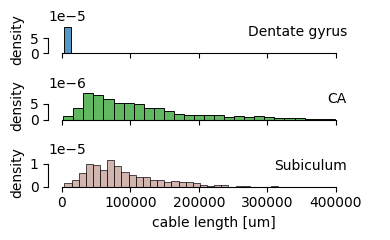

In [7]:
# Calculate cable lengths. N.B. that this is computed on-demand (and subsequently cached)
# and hence will take a few moments the first time it is called.
cl = nl.cable_length

# Compile data
data = pd.DataFrame()
data["id"] = nl.id
data["cable_length"] = cl
data["region"] = nl.region

# Add coarse region labels
data["region_coarse"] = None
data.loc[data.region.str.contains("Dentate", na=False), "region_coarse"] = (
    "Dentate gyrus"
)
data.loc[data.region.str.contains("CA", na=False), "region_coarse"] = "CA"
data.loc[
    data.region.str.lower().str.contains("subiculum", na=False), "region_coarse"
] = "Subiculum"
data["hemisphere"] = nl.hemisphere

# Plot!
fig, axes = plt.subplots(nrows=3, figsize=(4, 2.5), sharex=True)
for i, t in enumerate(type_coarse_colors):
    sns.histplot(
        data=data[data.region_coarse == t],
        x="cable_length",
        bins=30,
        color=type_coarse_colors[t],
        ax=axes[i],
        stat="density",
    )
    axes[i].text(0.9, 1, t, transform=axes[i].transAxes, va="top", ha="right")
    axes[i].set_ylabel("density")

axes[-1].set_xlabel("cable length [um]")

sns.despine(trim=True)
plt.tight_layout()

In [13]:
# Split into l/r neurons
left = nl[nl.hemisphere == "Left"]
right = nl[nl.hemisphere == "Right"]

# Mirror left to right (because CCF is symmetric, this is a simple flip)
left_flip = navis.mirror_brain(left, template="AllenCCF", mirror_axis="z")

# Re-combine right and the flipped left into a single neuron list
nl_all_right = right + left_flip

Mirroring:   0%|          | 0/669 [00:00<?, ?it/s]

In [ ]:
# Turn into dotprops
dp = navis.make_dotprops(nl_all_right, k=5, parallel=True, resample=5)

In [ ]:
# To avoid potential issues with multiple layers of concurrency during NBLAST, we will set the
# number of OMP threads to 1. Whether or not this is actually necessary will depend on your
# system but better safe than sorry.
import os

os.environ["OMP_NUM_THREADS"] = "1"

# Note: we're using the old v1 scoring function here
scores = navis.nblast_allbyall(
    dp, n_cores=10, smat="v1", smat_kwargs=dict(sigma_scoring=30)
)
scores.index = scores.columns = dp.name

# Calculate the mean of the forward and reverse scores
scores_mean = (scores + scores.values.T) / 2

os.environ.pop("OMP_NUM_THREADS")  # drop OMP throttling

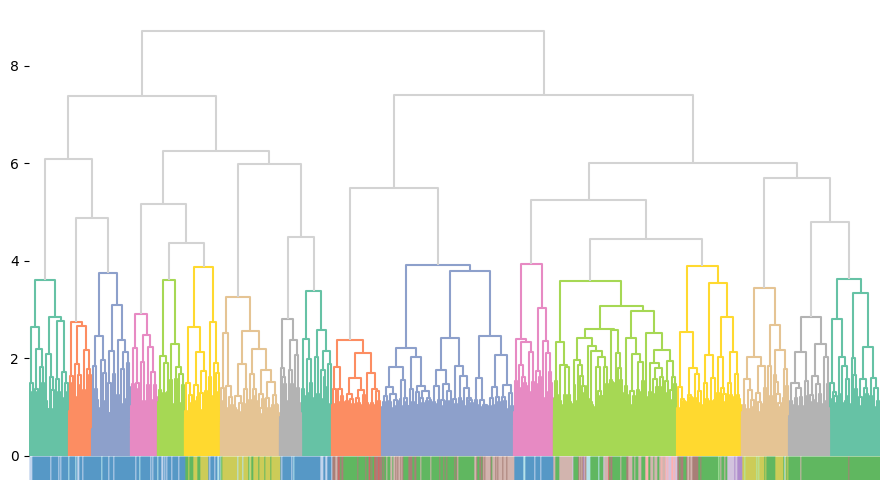

In [24]:
# Plot a dendrogram of the clustering
from scipy.cluster.hierarchy import (
    linkage,
    dendrogram,
    cut_tree,
    set_link_color_palette,
)
from scipy.spatial.distance import squareform
from matplotlib.collections import PatchCollection
from matplotlib.patches import Rectangle

# Make the figure
fig, ax = plt.subplots(figsize=(9, 5))

# Plot dendrogram
Z = linkage(squareform(1 - scores_mean), method="ward")
set_link_color_palette([c.hex for c in cmap.Colormap("colorbrewer:set2").iter_colors()])
dn = dendrogram(
    Z, no_labels=True, ax=ax, above_threshold_color="lightgray", color_threshold=4
)

# Here, we add little colored rectangles to the plot to indicate the type of each neuron
rects = []
for i, d in enumerate(dn["leaves"]):
    r = Rectangle(
        (i * 10, 0),
        10,
        -0.5,
        facecolor=type_colors[nl_all_right[d].region],
        edgecolor="none",
    )
    rects.append(r)
ax.add_collection(PatchCollection(rects, match_original=True))
ax.set_ylim(bottom=-0.5)

sns.despine(left=True, bottom=True)
plt.tight_layout()

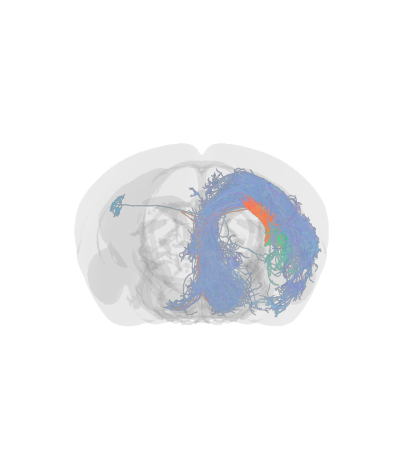

In [21]:
# Extract clusters and plot some of them
cl = cut_tree(Z, height=4).flatten()


def vary_color(rgba, scale=0.05):
    """Vary color slightly."""
    r, g, b, a = rgba
    dr, dg, db = np.random.normal(scale=scale, size=3)
    return tuple(np.clip(np.array([r + dr, g + dg, b + db, a]), a_min=0, a_max=1))


# Start a viewer in offscreen mode
v = oc.Viewer(offscreen=True)

# Add the Allen CCF mesh for reference
v.add_mesh(mousebrains.AllenCCF.mesh, color="lightgray", alpha=0.05)

# Add neurons colored by cluster
colors = list(cmap.Colormap("colorbrewer:set2").iter_colors())
for i, c in enumerate([0, 2, 6]):  # Plot the a few of the smaller clusters
    this = nl_all_right[cl == c]
    v.add_neuron(this, color=[vary_color(colors[i].rgba) for n in this], linewidth=1)

# Set view to frontal
v.set_view("YZ")

# Render image to matplotlib figure
_ = plt.imshow(v._screenshot(size=(1920, 1080)))

# Adjust the aspect ratio and remove axes
ax = plt.gca()
ax.set_aspect("equal")
ax.set_xlim(1000, 2800)
ax.set_axis_off()
plt.tight_layout()

v.close()  # Close the viewer